## **Northeastern SMILE Lab - Recognizing Faces in the Wild**

## Background

The SMILE Lab at Northeastern focuses on the frontier research of applied machine learning, social media analytics, human-computer interaction, and high-level image and video understanding. Their research is driven by the explosion of diverse multimedia from the Internet, including both personal and publicly available photos and videos. They start by treating fundamental theory from learning algorithms as the soul of machine intelligence and arm it with visual perception.

Northeastern University has been developing an automatic kinship classifier since 2010. However, the widespread adoption of this technology has been hindered by two primary factors:

- Data Limitations: Existing image databases for kinship recognition are insufficient in size and diversity to accurately represent global familial relationships.

- Model Complexity: The complex interplay of genetic and environmental factors influencing facial features necessitates a more advanced model than traditional computer vision algorithms, which are typically designed for higher-level tasks like facial recognition or object classification.

## Objective

Using the data provided in this competition, I built the following model to predict the probability of two individuals being related (1) based solely on a facial image of each person. 

## **Preliminaries**: Install the following Python modules.

In [ ]:
# The following commands install these module dependencies, if they are not already installed.
%pip install os
%pip install kaggle
%pip install zipfile
%pip install pandas
%pip install matplotlib
%pip install sklearn

## **Step 1**: Download the official Kaggle competition data (a.k.a. FIW data).

***Before executing the following cell***, please review section 7 of the rules: https://www.kaggle.com/competitions/recognizing-faces-in-the-wild/rules#7-competition-data. 

All usages of FIW data should cite the following papers:

*Joseph P Robinson, Ming Shao, Hongfu Liu, Yue Wu, Timothy Gillis, and Yun Fu. "Visual Kinship Recognition of Families In the Wild" IEEE TPAMI Special Edition: Computational Face (2018).
Joseph P Robinson, Ming Shao, Handong Zhao, Yue Wu, Timothy Gillis, Yun Fu. "Recognizing Families In the Wild (RFIW): Data Challenge Workshop in conjunction with ACM MM 2017," ACM Multimedia Conference: Workshop on RFIW (2017).
Shuyang Wang, Joseph P Robinson, and Yun Fu. “Kinship Verification on Families in the Wild with Marginalized Denoising Metric Learning,” in IEEE Automatic Face and Gesture Recognition (2017).
Joseph P Robinson, Ming Shao, Yue Wu, and Yun Fu. “Families In the Wild (FIW): large-scale kinship image database and benchmarks." in ACM on Multimedia Conference (2016).*

In [ ]:
import os
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

competition = 'recognizing-faces-in-the-wild' # https://www.kaggle.com/c/recognizing-faces-in-the-wild
download_path = '_FIW-data/'
extract_path =  '_FIW-data-extracted/'
zip_file = os.path.join(download_path, f'{competition}.zip')

print('Recreating intermediate directory: ' + download_path)
if os.path.exists(download_path):
    shutil.rmtree(download_path)
os.makedirs(download_path, exist_ok=False)
print('Downloading ' + competition + ' provided data into ' + download_path)
api = KaggleApi()
api.authenticate()
api.competition_download_files(competition, path=download_path)

print('Recreating intermediate directory: ' + extract_path)
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)
os.makedirs(extract_path, exist_ok=False)
print('Decompressing ' + zip_file + ' into ' + extract_path)
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print('Data files:')
for dirname, _, filenames in os.walk(extract_path):
    for filename in filenames:
        print('\t' + os.path.join(dirname, filename))

Recreating intermediate directory: _FIW-data/
Recreating intermediate directory: _FIW-data-extracted/
Decompressing _FIW-data/recognizing-faces-in-the-wild.zip into _FIW-data-extracted/
Data files:
	_FIW-data-extracted/README.md
	_FIW-data-extracted/sample_submission.csv
	_FIW-data-extracted/test-faces.zip
	_FIW-data-extracted/test-private-faces.zip
	_FIW-data-extracted/test-private-labels.zip
	_FIW-data-extracted/test-private-lists.zip
	_FIW-data-extracted/test-public-faces.zip
	_FIW-data-extracted/test-public-lists.zip
	_FIW-data-extracted/test.zip
	_FIW-data-extracted/train-faces.zip
	_FIW-data-extracted/train.zip
	_FIW-data-extracted/train_relationships.csv


## **Step 2**: Extract the image portion of the provided dataset.

In [ ]:
training_set = 'train-faces'
training_set_path = extract_path + training_set + '-extracted/'
print('Recreating intermediate directory: ' + training_set_path)
if os.path.exists(training_set_path):
    shutil.rmtree(training_set_path)
os.makedirs(training_set_path, exist_ok=False)
print('Decompressing ' + training_set + ' into ' + training_set_path)
with zipfile.ZipFile(extract_path + training_set + '.zip', 'r') as zip_ref:
    zip_ref.extractall(training_set_path)
print('Training image set:')
for dirname, _, filenames in os.walk(training_set_path):
    for filename in filenames:
        print('\t' + os.path.join(dirname, filename))

Recreating intermediate directory: _FIW-data-extracted/train-faces-extracted/
Decompressing train-faces into _FIW-data-extracted/train-faces-extracted/
_FIW-data-extracted/train-faces-extracted/:
	_FIW-data-extracted/train-faces-extracted/F0001\MID1\P00001_face2.jpg
	_FIW-data-extracted/train-faces-extracted/F0001\MID1\P00002_face3.jpg
	_FIW-data-extracted/train-faces-extracted/F0001\MID1\P00003_face1.jpg
	_FIW-data-extracted/train-faces-extracted/F0001\MID1\P00004_face3.jpg
	_FIW-data-extracted/train-faces-extracted/F0001\MID1\P00007_face2.jpg
	_FIW-data-extracted/train-faces-extracted/F0001\MID1\P00008_face7.jpg
	_FIW-data-extracted/train-faces-extracted/F0001\MID2\P00001_face1.jpg
	_FIW-data-extracted/train-faces-extracted/F0001\MID2\P00002_face2.jpg
	_FIW-data-extracted/train-faces-extracted/F0001\MID2\P00003_face2.jpg
	_FIW-data-extracted/train-faces-extracted/F0001\MID2\P00004_face1.jpg
	_FIW-data-extracted/train-faces-extracted/F0001\MID2\P00008_face2.jpg
	_FIW-data-extracted/tr

## **Step 3**: Preprocess the relational portion of the provided dataset.

Note: All members of a family are not necessarily related (e.g., husband/wife).

In [11]:
import pandas
ground_truth = pandas.read_csv(extract_path + 'train_relationships.csv', delimiter=',', header='infer')
print('Taining images which are related:')
print(ground_truth)

              p1          p2
0     F0002/MID1  F0002/MID3
1     F0002/MID2  F0002/MID3
2     F0005/MID1  F0005/MID2
3     F0005/MID3  F0005/MID2
4     F0009/MID1  F0009/MID4
...          ...         ...
3593  F1000/MID5  F1000/MID8
3594  F1000/MID5  F1000/MID9
3595  F1000/MID6  F1000/MID9
3596  F1000/MID7  F1000/MID8
3597  F1000/MID7  F1000/MID9

[3598 rows x 2 columns]


#### Evaluation (https://www.kaggle.com/competitions/recognizing-faces-in-the-wild/overview/evaluation)
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target. Not all pairs will be scored.

Submission File
For each img_pair in the test set, you must predict a probability for the is_related variable. The column img_pair describes the pair of images, i.e., abcdef-ghijkl means the pair of images abcdef.jpg and ghijkl.jpg.
The file should contain a header and have the following format:
```
img_pair,is_related
X3Nk6Hfe5x-qcZrTXsfde,0.0
X3Nk6Hfe5x-LD0pWDM8w_,0.0
X3Nk6Hfe5x-PHwuDtHyGp,0.0
X3Nk6Hfe5x-LO6lN_U4ot,0.0
...
```

In [ ]:
results = [
    {"true_label": 1, "predicted_prob": 0.8},
    {"true_label": 0, "predicted_prob": 0.2},
    {"true_label": 1, "predicted_prob": 0.7},
    {"true_label": 0, "predicted_prob": 0.3},
    {"true_label": 0, "predicted_prob": 0.8},
    {"true_label": 0, "predicted_prob": 0.2},
    {"true_label": 1, "predicted_prob": 0.7},
    {"true_label": 1, "predicted_prob": 0.3},
]

[1, 0, 1, 0, 0, 0, 1, 1]


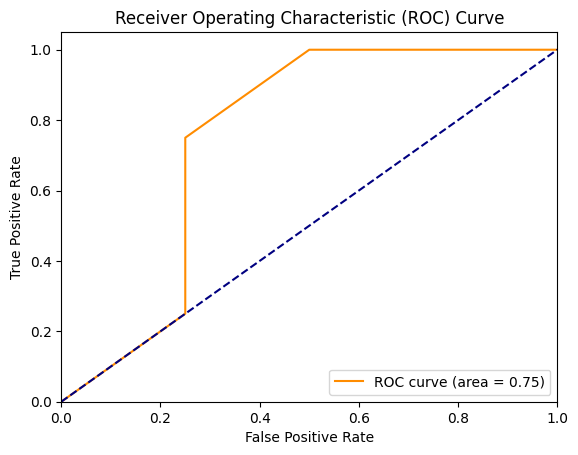

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def generate_roc_curve(data):
  true_labels = [d['true_label'] for d in data]
  print(true_labels)
  predicted_probs = [d['predicted_prob'] for d in data]
  fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  return plt
    
generate_roc_curve(results).show()